## to do

NOTE: no need to implement loads of gates! all I need to do is implement the X(pi/2) gate and figure out:
- how do i decompose any given gate into a set of these and virtual Z gates
- how does the fidelity of the X(pi/2) gate relate to the fidelity of any given gate?

then, i have no need for the whole clifford group faff: instead, measure X gate fidelity over some gates, and convert into predicted RBT?

however, how does this gel in with the stated aim of calculating the error budget? it relies on how exactly everything is implemented on the device: is only one gate implemented at a time?

### RBT
- implement and optimise the clifford group of gates. can the inbuilt generator be used?
- look at pygsti for inverses
- look at the paper for
  - leakage benchmarking
- if RBT doesn't work, you can just optimise each gate, simulate a number of times (if noise is implemented) and find the mean fidelity. this can then be compared with the online results

### noise
- add noise to the gates
- this is not high-frequency noise
- rather, each time the gate is run, add a sample from a normal distribution of some width to:
  - amplitude of the envelope
  - phase of the sinusoid
- frequency noise is due to transmon drift, not equipment drift. simulate separately, if at all. expected 1-100 kHz
- look at the old master's project to see what kind of noise (gaussian stdev) is expected in each parameter. experimental fidelity is high so we expect it to be small
  
### misc
- the error has three components: decoherence, leakage, and instrument noise
- decoherence error should come from the theoretical prediction in the paper
- leakage error can be found from the population of higher states. note the paper does not account for this
- noise error is therefore whatever is left over
- vary the noise parameters to reach the experimental results from either the paper or shuxiang's older work - ask him for it
- in the no-noise case, the theoretical + leakage should equal the simulated error, if not, the optimisation could be better
- the units should be MHz and microseconds
- reproduce numbers on the online paper - try and simulate each of the four qubits
- remove RWA
- what is the decomposition of an arbitrary gate (below) into X(pi/2) and virtual Z gates?

$$U(\theta,\phi,\lambda)=\begin{pmatrix}
\cos{\theta/2}&-e^{-\imath\lambda}\sin{\theta/2}\\
e^{\imath\phi}\sin{\theta/2}&e^{\imath(\phi+\lambda)}\cos{\theta/2}
\end{pmatrix}$$

In [1]:
# imports

from transmon import Transmon
from gates import MyGate
from optimiser import Optimiser, calculate_target_state
from shapes import sinusoid, blackman
from simulator import *
from RBT import *

from qutip import Bloch, Qobj
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# setup transmon, gates, t, optimiser

tr = Transmon(3, 0, 5000, -350)
# tr.ψ0 = (basis(3,0) + 1j*basis(3,1)).unit()

X180 = MyGate("X", 180)
X90 = MyGate("X", 90)
X_minus_90 = MyGate("X", -90)
Y180 = MyGate("Y", 180)
Y90 = MyGate("Y", 90)
Y_minus_90 = MyGate("Y", -90)

gateset = [X180, X90, X_minus_90, Y180, Y90, Y_minus_90]

t = np.linspace(0, 1, 1000)

opt = Optimiser(t, tr)

In [3]:
# define initial params
initial_params = {"A":15, "Γ":0.5, "ω":tr.Ω, "A_DRAG":0}

for i in gateset:
  i.optimal_parameters = initial_params

optimal_params=[{'A': 14.945766034322247,
  'Γ': 0.500884720499923,
  'ω': 5000.217416842387,
  'A_DRAG': 0.0007961947681925262},
 {'A': 7.764833438875867,
  'Γ': 0.5745422537900148,
  'ω': 5006.116558198628,
  'A_DRAG': -0.009431481748158995},
 {'A': 22.8377314938199,
  'Γ': 0.48436739055394723,
  'ω': 5003.363566874202,
  'A_DRAG': 0.010640971688763344},
 {'A': 14.974243184398027,
  'Γ': 0.4998495411819244,
  'ω': 5000.215880713061,
  'A_DRAG': 0.02758291237709352},
 {'A': 23.118618448654683,
  'Γ': 0.47855127257223584,
  'ω': 5003.380633775708,
  'A_DRAG': 0.005527715611418649},
 {'A': 23.1183663018904,
  'Γ': 0.478557147112774,
  'ω': 5003.38061192779,
  'A_DRAG': 0.005232817556283012}]

for i,v in enumerate(gateset):
  v.optimal_parameters = optimal_params[i]

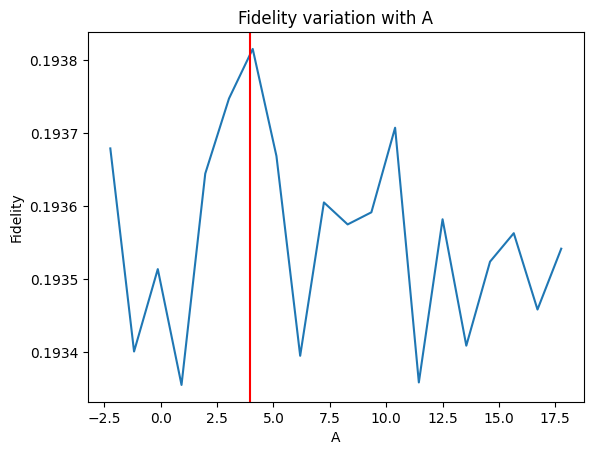

KeyboardInterrupt: 

In [4]:
opt.optimise_gate(X90, {"A":10,"ω":0.00001,"Γ":0.4,"A_DRAG":0.1}, plot=True)

In [ ]:
X90.optimal_parameters

{'A': 7.981329724258821,
 'Γ': 0.5945021691681521,
 'ω': 5006.1165525022925,
 'A_DRAG': -0.014376639033789705}

In [4]:
# optimise params
gates_semiranges = {
            X_minus_90:{"A":10,"ω":10,"Γ":0.4,"A_DRAG":0.1},
            X180:{"A":5,"ω":10,"Γ":0.4,"A_DRAG":0.1},
            X90: {"A":10,"ω":10,"Γ":0.4,"A_DRAG":0.1},
            Y_minus_90:{"A":10,"ω":10,"Γ":0.4,"A_DRAG":0.1},
            Y180: {"A":5,"ω":10,"Γ":0.4,"A_DRAG":0.1},
            Y90: {"A":10,"ω":10,"Γ":0.4,"A_DRAG":0.1},
        }

gateset = opt.optimise_gateset(gateset, gates_semiranges, plot=False)

(X180, X90, X_minus_90, Y180, Y90, Y_minus_90) = opt.optimise_gateset(gateset, gates_semiranges, plot=False)

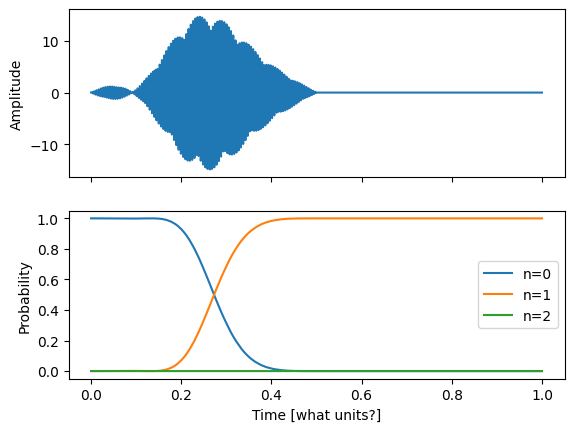

Final fidelity: 0.9999622180526432


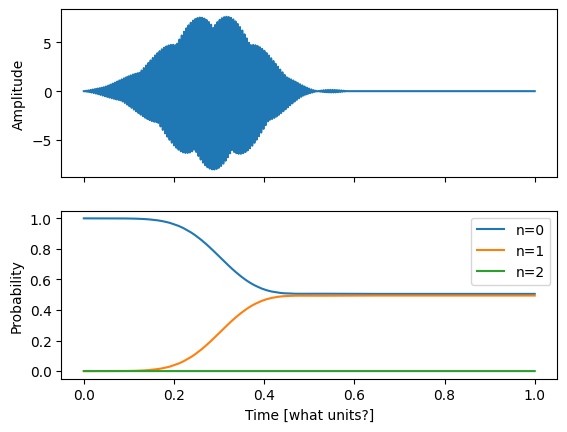

Final fidelity: 0.9996434355211049


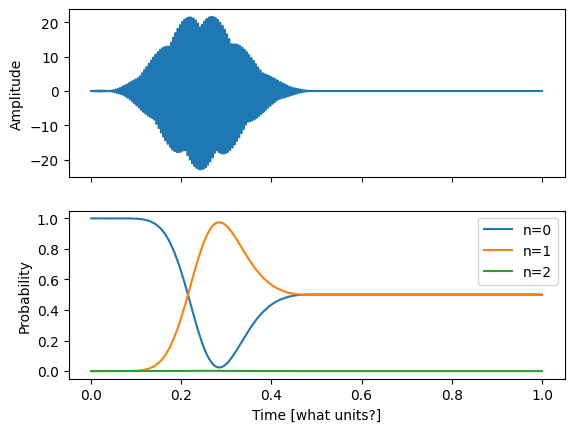

Final fidelity: 0.9998260166514273


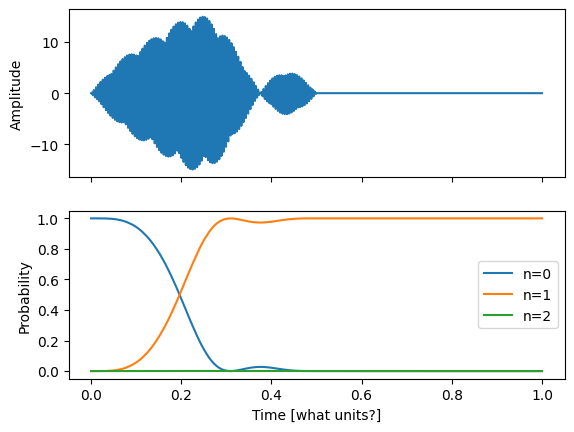

Final fidelity: 0.9999980144850229


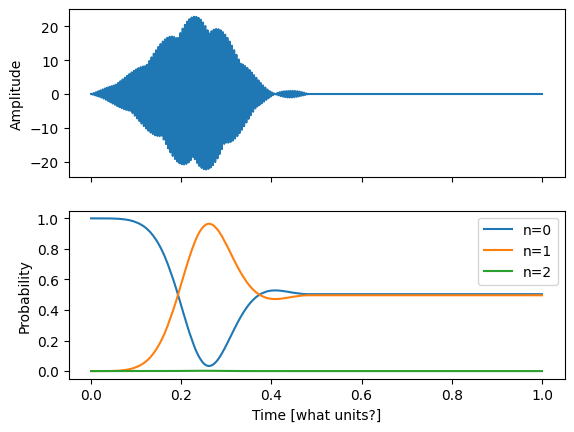

Final fidelity: 0.99950227746546


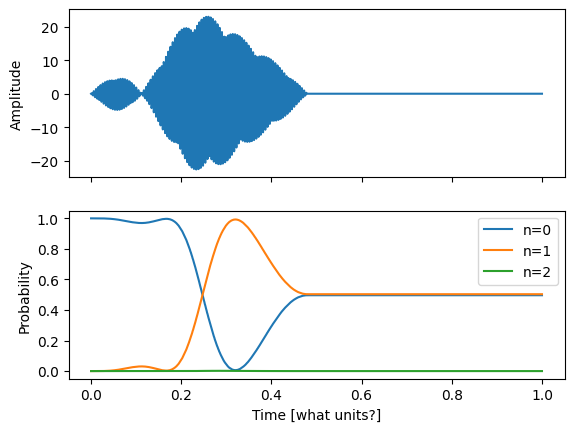

Final fidelity: 0.998858301412058


In [5]:
# simulate gates individually
results = simulate_gateset(t, gateset, tr)

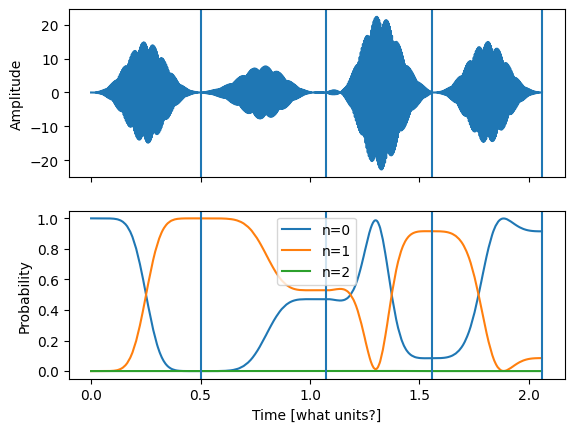

Final fidelity: 0.95658685921362


In [5]:
# simulate simple circuit
result, _ = simulate_circuit([X180, X90, X_minus_90, X180], tr, plot=True)


Testing sequences of length 1
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Testing sequences of length 2
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Testing sequences of length 3
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Testing sequences of length 4
oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Testing sequences of length 5
ooooooooooooooooooooooooooooooooooooooooo

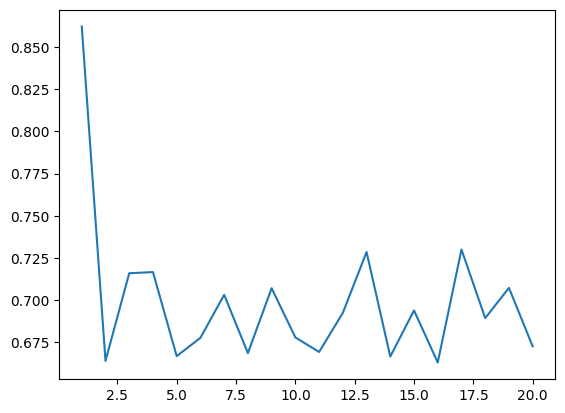

In [7]:
# perform RBT
gateset_with_inverses = [(X180, X180), (X90, X_minus_90), (X_minus_90, X90), (Y180, Y180), (Y90, Y_minus_90), (Y_minus_90, Y90)]
performance = RBT(gateset_with_inverses, tr, 100, 20)